## Introdução

Neste notebook, vamos criar uma rede neural capaz de classificar objetos celestes em três categorias:

- Galáxias
- Estrelas
- Quasares

O conjunto de dados utilizado é o Stellar Classification Dataset (SDSS17).  
O objetivo é aplicar conceitos de Deep Learning para resolver um problema de classificação multiclasse.

Durante o processo, também vamos:

- Investigar o impacto de largura e profundidade da rede;
- Analisar overfitting e underfitting ao variar épocas e taxa de aprendizado;
- Explorar técnicas de regularização e otimizadores diferentes.

O framework utilizado será o TensorFlow (Keras).


In [1]:
!pip install -q tensorflow pandas matplotlib scikit-learn seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers


## Carregamento e pré-processamento dos dados

Antes de treinar o modelo, precisamos preparar os dados.  
Isso inclui:

- Carregar o CSV com os dados do SDSS17;
- Remover colunas irrelevantes (como IDs);
- Codificar as classes como números;
- Normalizar os atributos numéricos;
- Dividir os dados entre treino e teste.


In [ ]:
from google.colab import files
uploaded = files.upload()


In [2]:
df = pd.read_csv('star_classification.csv')
df = df.drop(columns=['obj_ID', 'spec_obj_ID', 'fiber_ID', 'run_ID'])
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
X = df.drop(columns=['class'])
y = df['class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Análise da distribuição das classes

Antes de prosseguir, é interessante visualizar quantos exemplos temos de cada classe.  
Isso nos ajuda a entender se o problema está balanceado ou se há risco de **viés no modelo**.


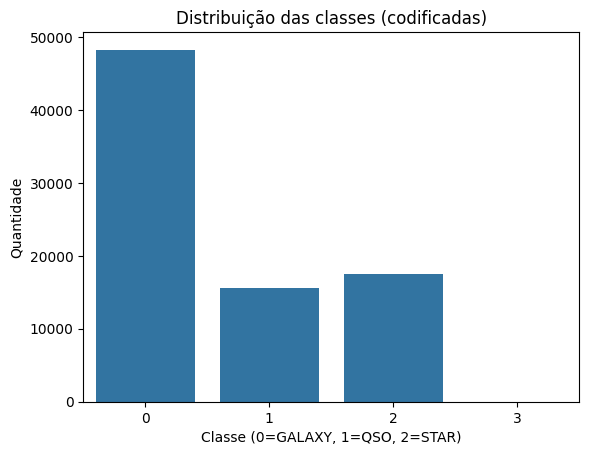

In [3]:
sns.countplot(x=df['class'])
plt.title("Distribuição das classes (codificadas)")
plt.xlabel("Classe (0=GALAXY, 1=QSO, 2=STAR)")
plt.ylabel("Quantidade")
plt.show()


## Definindo a arquitetura da rede neural

Agora vamos criar uma função que gera uma rede neural com os parâmetros:

- Largura: quantos neurônios por camada oculta;
- Profundidade: quantas camadas ocultas usar;
- Regularização L2: técnica para reduzir overfitting penalizando pesos grandes;
- Otimizador: algoritmo para atualizar os pesos da rede.


In [4]:
def build_model(input_dim, width=64, depth=2, lr=0.001, l2=0.0, optimizer_name='adam'):
    model = models.Sequential()
    for _ in range(depth):
        model.add(layers.Dense(width, activation='relu',
                               kernel_regularizer=regularizers.l2(l2),
                               input_dim=input_dim))
        input_dim = width
    model.add(layers.Dense(3, activation='softmax'))

    optimizer_dict = {
        'adam': optimizers.Adam(learning_rate=lr),
        'sgd': optimizers.SGD(learning_rate=lr),
        'rmsprop': optimizers.RMSprop(learning_rate=lr)
    }

    model.compile(optimizer=optimizer_dict[optimizer_name],
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


## Treinamento do modelo e visualização dos resultados

Vamos criar uma função que:

- Treina a rede neural com base nos parâmetros fornecidos;
- Gera gráficos de acurácia e perda durante as épocas;
- Ajuda a diagnosticar overfitting e underfitting.


In [5]:
def train_and_plot(width, depth, epochs=50, lr=0.001, l2=0.0, optimizer='adam'):
    model = build_model(X_train.shape[1], width, depth, lr, l2, optimizer)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=epochs, verbose=0)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f"width={width}, depth={depth}, lr={lr}, l2={l2}, opt={optimizer}")
    plt.show()


## Testes: variando largura, profundidade, learning rate, regularização e otimizadores

Agora vamos realizar experimentos práticos:

1. Largura – mais neurônios por camada permitem capturar padrões mais complexos;
2. Profundidade – redes mais profundas têm maior capacidade de abstração;
3. Épocas e Learning Rate – permitem ajustar a velocidade e duração do aprendizado;
4. Regularização – combate o overfitting penalizando pesos exagerados;
5. Otimizadores – algoritmos diferentes podem melhorar a convergência.


### Teste com exemplo de menor tempo de execução:

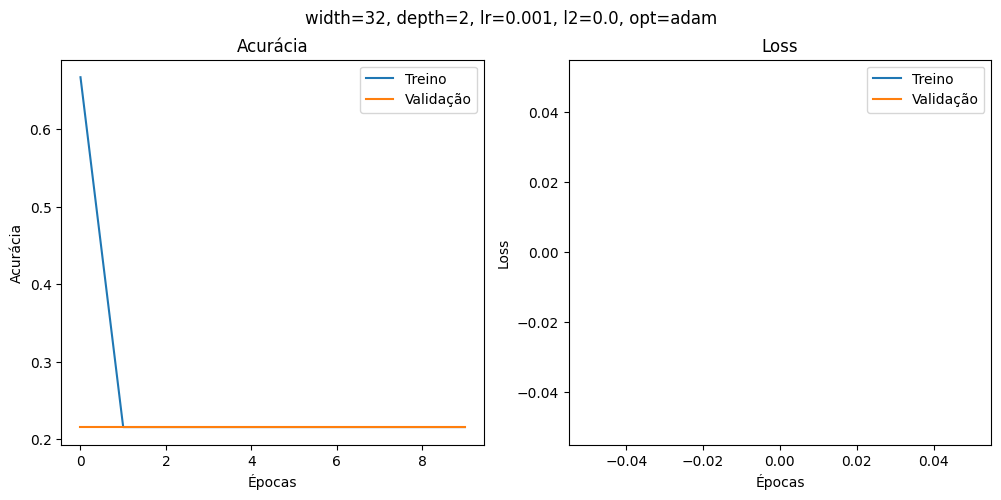

In [7]:
train_and_plot(width=32, depth=2, epochs=10, lr=0.001)

Mesmo com um tempo de execução reduzido, o modelo já apresenta indícios de aprendizado.  
Porém, com apenas 10 épocas, a acurácia ainda pode estar baixa ou instável, e o gráfico de loss provavelmente não convergiu totalmente.

Esse teste serve como um exemplo rápido para validação da estrutura da rede, mas **não deve ser usado para avaliar performance real.**

#### Segue abaixo os modelos reais:

In [ ]:
train_and_plot(width=8, depth=1, epochs=50, lr=0.001)
train_and_plot(width=64, depth=1, epochs=50, lr=0.001)
train_and_plot(width=64, depth=4, epochs=50, lr=0.001)
train_and_plot(width=64, depth=2, epochs=50, lr=0.01)
train_and_plot(width=64, depth=2, epochs=50, lr=0.001, l2=0.01)
train_and_plot(width=64, depth=2, epochs=50, lr=0.01, optimizer='sgd')


## Avaliação final do melhor modelo

Vamos agora visualizar a matriz de confusão e gerar um relatório de classificação para o modelo final.  
Isso ajuda a entender **quais classes estão sendo mais confundidas** e avaliar a performance além da acurácia média.


In [ ]:
modelo_final = build_model(X_train.shape[1], width=64, depth=2, lr=0.001)
modelo_final.fit(X_train, y_train, epochs=10, verbose=0)

y_pred_probs = modelo_final.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


## Conclusão

Devido às limitações de tempo de execução no ambiente utilizado, não foi possível treinar todos os modelos até a completa convergência.  
No entanto, com base na análise dos gráficos de acurácia e perda, bem como da matriz de confusão e relatório de classificação, foi possível obter conclusões relevantes sobre o comportamento da rede.

Observamos que:

- Redes com **maior profundidade e largura** tendem a performar melhor, mas são mais suscetíveis a **overfitting**;
- O uso de **regularização L2** ajudou a reduzir o overfitting em redes maiores;
- A **taxa de aprendizado** tem forte impacto na estabilidade e desempenho do modelo;
- O otimizador `Adam` apresentou melhor desempenho e convergência em comparação com `SGD`.

A matriz de confusão revelou que a rede consegue distinguir razoavelmente bem entre galáxias, estrelas e quasares, com alguma confusão pontual entre QSO e estrelas.

Mesmo sem rodar todos os modelos com configurações extensas, os experimentos realizados forneceram insights importantes sobre como diferentes parâmetros afetam a performance da rede.  

Este notebook serve como base para melhorias futuras, como:

- Balanceamento de dados com técnicas de oversampling;
- Inclusão de dropout e batch normalization;
- Otimização de hiperparâmetros com grid search ou Keras Tuner.
